# YoloV1

This notebook uses the YoloV1 architecture declared [here](./YoloV1.py). It is slightly modified from the original paper.

## Dataset
### Download
First let's prepare the dataset. The dataset used is from [Kaggle](https://www.kaggle.com/datasets/734b7bcb7ef13a045cbdd007a3c19874c2586ed0b02b4afc86126e89d00af8d2), which contains 16550 training examples and 4951 testing examples.

Let's look at the dataset. The file directory looks like this
```
base_dir /
    train.csv
    test.csv
    images /
    labels /
```

Labels look like this
```python
# Class, Relative X to entire Image, Relative Y to entire Image, Relative W to entire Image, Relative H to entire Image
11 0.34419263456090654 0.611 0.4164305949008499 0.262
14 0.509915014164306 0.51 0.9745042492917847 0.972
```

Images look like this
```


```

In [1]:
# Classes
# Person: person
# Animal: bird, cat, cow, dog, horse, sheep
# Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
# Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

class_to_index = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}

index_to_class = {0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor'}
# index_to_class = {v: k for k, v in class_to_index.items()}
# print(index_to_class)


### Custom Dataset Loader

In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.utils.data.dataloader.DataLoader as DataLoader
import torch.optim as optim
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())
print(device)
print("Start")

Tesla V100-PCIE-16GB
cuda:0
Start


In [3]:
# Custom Dataset
class VOCDataset(Dataset):
    """ Custom Dataset for VOC Dataset"""
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        
    def __len__(self):
        """ Length of the dataset"""
        return len(self.annotations)
    
    def __getitem__(self, idx):
        """ Get item from the dataset"""
        label_path = os.path.join(self.label_dir, self.annotations.iloc[idx, 1])
        boxes = []
        with open(label_path) as f:
            # Read Labels
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]
                boxes.append([class_label, x, y, width, height])
              
        # Get image
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)
        
        # Perform transformations on dataset
        if self.transform:
            image, boxes = self.transform(image, boxes)
                      
        # Update labels with respect to cell 
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B)) # (S, S, 25), last 5 nodes unused
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)
            
            # Relative to a certain cell 
            i, j = int(self.S * y), int(self.S * x) # (cell row, cell col)
            x_cell, y_cell = self.S * x - j, self.S * y - i
            
            # Relative width and height
            width_cell, height_cell = (width * self.S, height * self.S)
            
            # If no object in i, j
            if label_matrix[i, j, 20] == 0:
                label_matrix[i, j, 20] = 1
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )
                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1
                
        return image, boxes           
    
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, img, bounding_boxes):
        for t in self.transforms:
            img, bounding_boxes = t(img), bounding_boxes
            
        return img, bounding_boxes
        
        

In [4]:
DATA_DIR = "~/Developer/Datasets/pascalvoc_yolo"
IMAGE_DIR = DATA_DIR + "/images"
LABEL_DIR = DATA_DIR + "/labels"

data_dir = os.path.expanduser(DATA_DIR)
csv_file = os.path.join(data_dir, 'train.csv')
img_file = os.path.join(data_dir, 'images')
label_file = os.path.join(data_dir, 'labels')

transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])
custom_dataset = VOCDataset(csv_file=csv_file, img_dir=img_file, label_dir=label_file, transform=transform)

## Visualize Data

Length of dataset: 16550
Shape of single item: torch.Size([3, 448, 448])


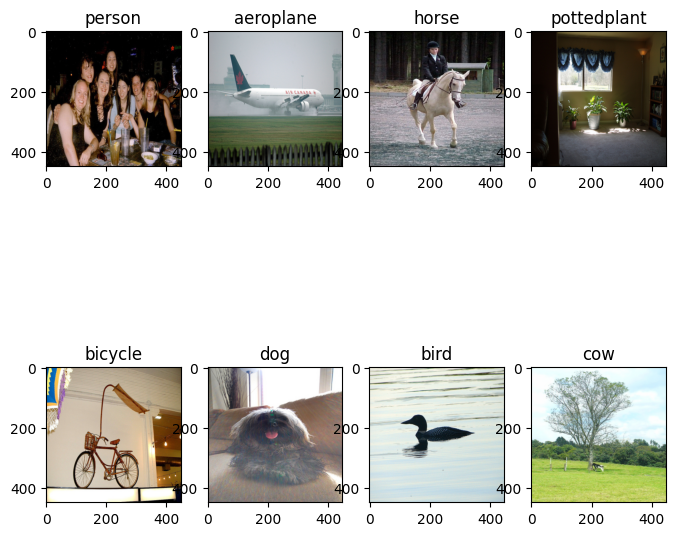

In [23]:
def plot_image(tensor: torch.Tensor):
    fig = plt.figure(figsize=(8, 8))
    cols, rows = 4, 2
    for i in range(1, cols*rows +1):
        # Get a random image from the dataset
        rand_index = np.random.randint(len(custom_dataset))
        image, label = custom_dataset[rand_index]
        numpy_array = image.numpy()
        fig.add_subplot(rows, cols, i)
        
        # Only plot the first one
        plt.imshow(numpy_array.transpose(1, 2, 0))
        plt.title(index_to_class[label[0][0].item()])
    

def plot_boxes(image, label):
    """ Plot image with bounding boxes"""
    img = to_pil_image(image)
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    print(label.shape)
    for b in label:
        bx, by, bw, bh = b[1:5] # (bx, by, bw, bh)
        # Convert to absolute coordinates
        bx, by, bw, bh = bx * 448, by * 448 + by, bw * 448, bh * 448
        # Move bx, by to top left corner
        bx, by = bx - bw / 2, by - bh / 2  
        rect = patches.Rectangle((bx, by), bw, bh, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Display label if provided
        if b[0]:
            plt.text(bx, by - 5, index_to_class[b[0].item()], color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

        # Show the plot
    plt.show()


print(f"Length of dataset: {len(custom_dataset)}")
print(f"Shape of single item: {custom_dataset[0][0].shape}")
plot_image(custom_dataset)


torch.Size([1, 5])
tensor(126.3360) tensor(67.8378)


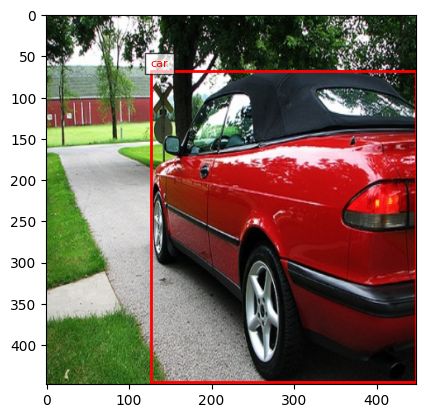

In [24]:
plot_boxes(custom_dataset[0][0], custom_dataset[0][1])

torch.Size([4, 5])
tensor(61.8240) tensor(206.1520)
tensor(134.4000) tensor(169.0147)
tensor(255.3600) tensor(240.8373)
tensor(231.1680) tensor(237.2466)


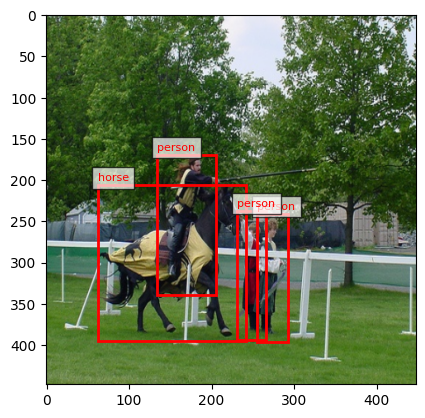

In [25]:
plot_boxes(custom_dataset[1][0], custom_dataset[1][1])

## Training and Evaluation

In [26]:
# Hyperparameters etc.
LEARNING_RATE = 2e-5
BATCH_SIZE = 32
WEIGHT_DECAY = 0
EPOCH = 100
NUM_WORKERS = 2
LOAD_MODEL = False
LOAD_MODEL_FILE = ""
SAVE_MODEL = True

from YoloV1 import YOLOV1, YoloV1Loss

loss_fn = YoloV1Loss(S=7, B=2, C=20)
model = YOLOV1(split_size=7, num_boxes=2, num_classes=20).to(device)

In [ ]:
def train_step(model: nn.Module,
               loss_fn: nn.Module,
               data_loader: DataLoader,
               optimizer: optim.Optimizer,
               device: str
            ):
    pass

def test_step(model: nn.Module,
                loss_fn: nn.Module,
                data_loader: DataLoader,
                optimizer: optim.Optimizer,
                device: str,
            ):
    pass

def train(model: nn.Module,
            train_loader: DataLoader,
            test_loader: DataLoader,
            optimizer: optim.Optimizer,
            loss_fn: nn.Module,
            epochs: int,
            device: str,
            ):
    
    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in range(epochs):
        pass
    
    
        
    return history

## Summary